In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
import keras
import h5py
import utils
import numpy as np
import matplotlib.pyplot as plt
import atlas_mpl_style
plt.style.use('atlas')
from matplotlib.ticker import PercentFormatter
from collections import namedtuple
import yaml

Using TensorFlow backend.


In [2]:
import genconfig
from train_MDN import train_nn, mixture_density_loss
Option = namedtuple("MyStruct", "training_input training_output validation_fraction outFile network_type \
                    config structure learning_rate regularizer epochs")

In [ ]:
def plotResidual(y_pred, y_valid, nbins=10000):
    nparticles = int(y_pred.shape[1]/2)
    fig, axs = plt.subplots(nparticles,2,sharey=True,sharex=True,tight_layout=True, figsize=[4*nparticles,12])
    axs[0][0].set_xlim([-10,10])
    for i in range(0,nparticles):
        axs[i][0].hist(pred_mean[:,i] - y_valid[:,i], bins=n_bins, density=True, histtype='step')
        axs[i][0].grid(True, linestyle='-.')
        axs[i][0].title.set_text('x'+str(i+1)+' mean')
        axs[i][1].hist(pred_mean[:,i+1] - y_valid[:,i+1], bins=n_bins, density=True, histtype='step')
        axs[i][1].grid(True, linestyle='-.')
        axs[i][1].title.set_text('y'+str(i+1)+' mean')
    plt.show()
    plt.close()

# One Particle

In [3]:
with h5py.File('NNinput_pos1_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [28]:
trainedModelFile = "Trained/pos1_06_16_1142"
trained_model = tf.keras.models.load_model(trainedModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
trained_model.load_weights('Trained/pos1_best.h5')

In [ ]:
trained_model.summary()

In [29]:
trained_pred = trained_model.predict(x_valid)

In [30]:
pred_mean_trained = trained_pred[:,1:3]
pred_std_trained = 1/np.sqrt(trained_pred[:,3:5])

In [31]:
trained_pred_mean_mean_x = "{:.3f}".format(np.average(pred_mean_trained[:,0]))
trained_pred_mean_mean_y = "{:.3f}".format(np.average(pred_mean_trained[:,1]))
trained_pred_std_mean_x = "{:.3f}".format(np.average(pred_std_trained[:,0]))
trained_pred_std_mean_y = "{:.3f}".format(np.average(pred_std_trained[:,1]))

#### Elham's Pre-Trained Model

In [8]:
trained_model.load_weights('weights_pos1.h5')

In [9]:
pretrained_pred = trained_model.predict(x_valid)

In [10]:
pred_mean_pretrained = pretrained_pred[:,1:3]
pred_std_pretrained = 1/np.sqrt(pretrained_pred[:,3:5])

In [27]:
pretrained_pred_mean_mean_x = "{:.3f}".format(np.average(pred_mean_pretrained[:,0]))
pretrained_pred_mean_mean_y = "{:.3f}".format(np.average(pred_mean_pretrained[:,1]))
pretrained_pred_std_mean_x = "{:.3f}".format(np.average(pred_std_pretrained[:,0]))
pretrained_pred_std_mean_y = "{:.3f}".format(np.average(pred_std_pretrained[:,1]))

print(type(pretrained_pred_mean_mean_x))

<class 'str'>


### Residuals

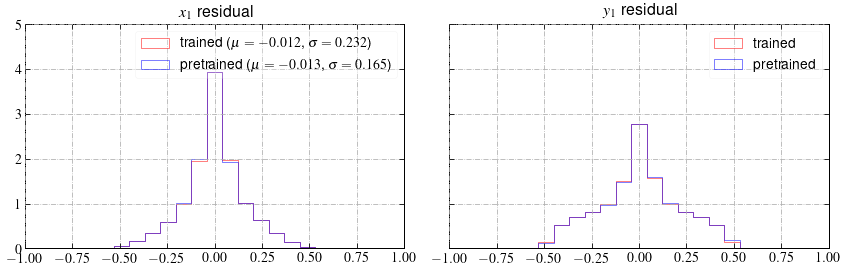

In [46]:
nbins = np.linspace(-2,2,50)
nparticles = int(pred_mean_trained.shape[1]/2)
fig, ax = plt.subplots(nparticles, 2, sharey=True,sharex=True, tight_layout=True, figsize=[12,4*nparticles])
ax[0].set_xlim([-1,1])
ax[0].hist(pred_mean_trained[:,0] - y_valid[:,0], bins=nbins, density=True, histtype='step', color='r')
ax[0].errorbar()
ax[0].hist(pred_mean_pretrained[:,0] - y_valid[:,0], bins=nbins, density=True, histtype='step', color='b')
ax[0].grid(True, linestyle='-.')
ax[0].title.set_text('$x_1$ residual')
ax[0].legend(['trained ($\mu = '+trained_pred_mean_mean_x+'$, $\sigma = '+trained_pred_std_mean_x+'$)',
              'pretrained ($\mu = '+pretrained_pred_mean_mean_x+'$, $\sigma = '+pretrained_pred_std_mean_x+'$)'])
ax[1].hist(pred_mean_trained[:,1] - y_valid[:,1], bins=nbins, density=True, histtype='step', color='r')
ax[1].hist(pred_mean_pretrained[:,1] - y_valid[:,1], bins=nbins, density=True, histtype='step', color='b')
ax[1].grid(True, linestyle='-.')
ax[1].title.set_text('$y_1$ residual')
ax[1].legend(['trained', 'pretrained'])
plt.savefig('1particleResiduals.png')
plt.show()
plt.close()

### Pulls

In [ ]:
nbins=10000
nparticles = int(pred_mean_trained.shape[1]/2)
fig, ax = plt.subplots(nparticles, 2, sharey=True,sharex=True, tight_layout=True, figsize=[12,4*nparticles])
ax[0].set_xlim([-3,3])
ax[0].hist((pred_mean_trained[:,0] - y_valid[:,0])/pred_std_trained[:,0], bins=nbins, density=True, histtype='step', color='r',)
ax[0].hist(pred_mean_pretrained[:,0] - y_valid[:,0], bins=nbins, density=True, histtype='step', color='b')
ax[0].grid(True, linestyle='-.')
ax[0].title.set_text('x1 pull')
ax[0].legend(['trained', 'pretrained'])
ax[1].hist((pred_mean_trained[:,1] - y_valid[:,1])/pred_std_pretrained[:,1], bins=nbins, density=True, histtype='step', color='r')
ax[1].hist(pred_mean_pretrained[:,1] - y_valid[:,1], bins=nbins, density=True, histtype='step', color='b')
ax[1].grid(True, linestyle='-.')
ax[1].title.set_text('y1 pull')
ax[1].legend(['trained', 'pretrained'])
plt.savefig('1particlePulls.png')
plt.show()
plt.close()

# Two Particles

In [ ]:
with h5py.File('NNinput_pos2_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [ ]:
trainedModelFile = "Trained/pos2_06_15_2358"
trained_model = tf.keras.models.load_model(trainedModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
trained_model.load_weights('Trained/pos2_06_04_0556_best.h5')

In [ ]:
trained_model.summary()

In [ ]:
trained_pred = trained_model.predict(x_valid)

In [ ]:
pred_mean_trained = np.hstack((trained_pred[0][:,1:3], trained_pred[1][:,1:3]))
pred_std_trained = 1/np.sqrt(np.hstack((trained_pred[0][:,3:5], trained_pred[1][:,3:5])))

#### Elham's Pre-Trained Model

In [ ]:
trained_model.load_weights('weights_pos2.h5')

In [ ]:
pretrained_pred = trained_model.predict(x_valid)

In [ ]:
pred_mean_pretrained = np.hstack((pretrained_pred[0][:,1:3], pretrained_pred[1][:,1:3]))
pred_std_pretrained = 1/np.sqrt(np.hstack((pretrained_pred[0][:,3:5], pretrained_pred[1][:,3:5])))

### Residuals

In [ ]:
nbins=10000
nparticles = int(pred_mean_trained.shape[1]/2)
fig, axs = plt.subplots(nparticles,2,sharey=True,sharex=True,tight_layout=True, figsize=[12,4*nparticles])
axs[0][0].set_xlim([-4,4])
for i in range(0,nparticles):
    axs[i][0].hist(pred_mean_trained[:,i] - y_valid[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][0].hist(pred_mean_pretrained[:,i] - y_valid[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][0].grid(True, linestyle='-.')
    axs[i][0].title.set_text('x'+str(i+1)+' residual')
    axs[i][0].legend(['trained', 'pretrained'])
    axs[i][1].hist(pred_mean_trained[:,i+1] - y_valid[:,i+1], bins=nbins, density=True, histtype='step', color='r')
    axs[i][1].hist(pred_mean_pretrained[:,i+1] - y_valid[:,i+1], bins=nbins, density=True, histtype='step', color='b')
    axs[i][1].grid(True, linestyle='-.')
    axs[i][1].title.set_text('y'+str(i+1)+' residual')
    axs[i][1].legend(['trained', 'pretrained'])
plt.savefig('2particleResiduals.png')
plt.show()
plt.close()

### Pulls

In [ ]:
nbins=10000
nparticles = int(pred_mean_trained.shape[1]/2)
fig, axs = plt.subplots(nparticles,2,sharey=True,sharex=True,tight_layout=True, figsize=[12,4*nparticles])
axs[0][0].set_xlim([-4,4])
for i in range(0,nparticles):
    axs[i][0].hist((pred_mean_trained[:,i] - y_valid[:,i])/pred_std_trained[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][0].hist((pred_mean_pretrained[:,i] - y_valid[:,i])/pred_std_pretrained[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][0].grid(True, linestyle='-.')
    axs[i][0].title.set_text('x'+str(i+1)+' pull')
    axs[i][0].legend(['trained', 'pretrained'])
    axs[i][1].hist((pred_mean_trained[:,i+1] - y_valid[:,i+1])/pred_std_trained[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][1].hist((pred_mean_pretrained[:,i+1] - y_valid[:,i+1])/pred_std_pretrained[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][1].grid(True, linestyle='-.')
    axs[i][1].title.set_text('y'+str(i+1)+' pull')
    axs[i][1].legend(['trained', 'pretrained'])
plt.savefig('2particlePulls.png')
plt.show()
plt.close()

# Three Particles

In [ ]:
with h5py.File('NNinput_pos3_training.h5', 'r') as hf:  
    #x_train = hf['train_data_x'][:]
    #y_train = hf['train_data_y'][:]
    x_valid = hf['valid_data_x'][:]
    y_valid = hf['valid_data_y'][:]

#### Locally Trained Model

In [ ]:
trainedModelFile = "Trained/pos3_06_15_1624"
trained_model = tf.keras.models.load_model(trainedModelFile, custom_objects={'abs' : tf.keras.backend.abs,
                                                                        'loss' : mixture_density_loss(nb_components=1)})
trained_model.load_weights('Trained/pos3_06_15_1624_best.h5')

In [ ]:
trained_pred = trained_model.predict(x_valid)

In [ ]:
pred_mean_trained = np.hstack((trained_pred[0][:,1:3], trained_pred[1][:,1:3], trained_pred[2][:,1:3]))
pred_std_trained = 1/np.sqrt(np.hstack((trained_pred[0][:,3:5], trained_pred[1][:,3:5], trained_pred[2][:,3:5])))

#### Elham's Pre-Trained Model

In [ ]:
trained_model.load_weights('weights_pos3.h5')

In [ ]:
pretrained_pred = trained_model.predict(x_valid)

In [ ]:
pred_mean_pretrained = np.hstack((pretrained_pred[0][:,1:3], pretrained_pred[1][:,1:3], pretrained_pred[2][:,1:3]))
pred_std_pretrained = 1/np.sqrt(np.hstack((pretrained_pred[0][:,3:5], pretrained_pred[1][:,3:5], pretrained_pred[2][:,3:5])))

### Residuals

In [ ]:
nbins=10000
nparticles = int(pred_mean_trained.shape[1]/2)
fig, axs = plt.subplots(nparticles,2,sharey=True,sharex=True,tight_layout=True, figsize=[12,4*nparticles])
axs[0][0].set_xlim([-4,4])
for i in range(0,nparticles):
    axs[i][0].hist(pred_mean_trained[:,i] - y_valid[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][0].hist(pred_mean_pretrained[:,i] - y_valid[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][0].grid(True, linestyle='-.')
    axs[i][0].title.set_text('x'+str(i+1)+' residual')
    axs[i][0].legend(['trained', 'pretrained'])
    axs[i][1].hist(pred_mean_trained[:,i+1] - y_valid[:,i+1], bins=nbins, density=True, histtype='step', color='r')
    axs[i][1].hist(pred_mean_pretrained[:,i+1] - y_valid[:,i+1], bins=nbins, density=True, histtype='step', color='b')
    axs[i][1].grid(True, linestyle='-.')
    axs[i][1].title.set_text('y'+str(i+1)+' residual')
    axs[i][1].legend(['trained', 'pretrained'])
plt.savefig('3particleResiduals.png')
plt.show()
plt.close()

### Pulls

In [ ]:
nbins=10000
nparticles = int(pred_mean_trained.shape[1]/2)
fig, axs = plt.subplots(nparticles,2,sharey=True,sharex=True,tight_layout=True, figsize=[12,4*nparticles])
axs[0][0].set_xlim([-4,4])
for i in range(0,nparticles):
    axs[i][0].hist((pred_mean_trained[:,i] - y_valid[:,i])/pred_std_trained[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][0].hist((pred_mean_pretrained[:,i] - y_valid[:,i])/pred_std_pretrained[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][0].grid(True, linestyle='-.')
    axs[i][0].title.set_text('x'+str(i+1)+' pull')
    axs[i][0].legend(['trained', 'pretrained'])
    axs[i][1].hist((pred_mean_trained[:,i+1] - y_valid[:,i+1])/pred_std_trained[:,i], bins=nbins, density=True, histtype='step', color='r')
    axs[i][1].hist((pred_mean_pretrained[:,i+1] - y_valid[:,i+1])/pred_std_pretrained[:,i], bins=nbins, density=True, histtype='step', color='b')
    axs[i][1].grid(True, linestyle='-.')
    axs[i][1].title.set_text('y'+str(i+1)+' pull')
    axs[i][1].legend(['trained', 'pretrained'])
plt.savefig('3particlePulls.png')
plt.show()
plt.close()